### Loading in files & libraries.

In [34]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from time import time

from collections import defaultdict, Counter

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.utils.extmath import density
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC



import warnings
warnings.filterwarnings("ignore")

In [35]:
# Import dataset, available on linked TCEQ web portal.

complaint_df = pd.read_csv('complaints.csv')

## Complaint Dataframe Exploration

### Initial Introductory Exploration

In [36]:
# First look, there are a lot of missing data points. This will be addressed by targeting the business problem 
# and focusing the dataset.
complaint_df.head()

,Customer Number,Customer Name,Regulated Entity Number,Regulated Entity Name,Mailing Address,Mailing State,Mailing Zip Code,County,Physical Location,Physical City,...,Incident Source,Incident Status,Incident Description,Incident Action Taken,Incident Comment,Material Released,Material Released Amount,Spill Classification,TCEQ Region,Coordinates (Decimal Degrees)
0,NaN,NaN,RN103341053,"RODRIGUEZ, OMAR",NaN,NaN,NaN,CAMERON,NaN,NaN,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 15 - HARLINGEN,NaN
1,NaN,NaN,RN103154688,I-10 EAST PLANT,NaN,NaN,NaN,HARRIS,UNSPECIFIED LOCATION,NaN,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 12 - HOUSTON,NaN
2,NaN,NaN,RN104032552,GENERIC INCIDENT ZIP CODE 75050,NaN,NaN,NaN,DALLAS,NaN,GRAND PRARIE,...,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,REGION 04 - DFW METROPLEX,NaN
3,NaN,NaN,RN101280493,COTTON VALLEY RV PARK,NaN,NaN,NaN,NO COUNTY NAME,NaN,NaN,...,NaN,CLOSED,FUEL LEAKING FROM DISPENSER #2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,RN104046297,GENERIC INCIDENT ZIP CODE 77550,NaN,NaN,NaN,GALVESTON,NaN,GALVESTON,...,NaN,CLOSED,Smells like sulfur.,Assigned to investigator.,NaN,NaN,NaN,NaN,REGION 12 - HOUSTON,NaN


In [37]:
# 215,548 entries and 33 columns. Predominantly object dtypes, which will change before EDA.
# Lots of redundancy around location.
complaint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215548 entries, 0 to 215547
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Customer Number                192445 non-null  object 
 1   Customer Name                  192445 non-null  object 
 2   Regulated Entity Number        215546 non-null  object 
 3   Regulated Entity Name          215546 non-null  object 
 4   Mailing Address                94682 non-null   object 
 5   Mailing State                  94682 non-null   object 
 6   Mailing Zip Code               94353 non-null   float64
 7   County                         215489 non-null  object 
 8   Physical Location              96982 non-null   object 
 9   Physical City                  178223 non-null  object 
 10  Latitude                       60650 non-null   float64
 11  Longitude                      60650 non-null   float64
 12  Incident Number               

In [38]:
# Here we find that most complaints come from Houston. They relate to the nature of an odor, 
# with the most common material released as sewage. Most claims are involve water-related complaints.
complaint_df.describe(include=object).T

,count,unique,top,freq
Customer Number,192445,33571,CN602295370,41316
Customer Name,192445,33367,GENERIC INCIDENT PRINCIPAL,41316
Regulated Entity Number,215546,47975,RN102610102,5642
Regulated Entity Name,215546,46417,BLUE RIDGE LANDFILL,5642
Mailing Address,94682,29017,2200 FM 521 RD,5642
Mailing State,94682,12,TX,94649
County,215489,255,HARRIS,15205
Physical Location,96982,26356,LOCATED ON 2200 FM 521,5642
Physical City,178223,2098,HOUSTON,7726
Incident Received Date,215548,7275,"Oct 29, 2018",292


In [39]:
# Most numerical columns don't provide true insight to the business problem. 
# The outlier in number complaining caught my eye.
complaint_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Mailing Zip Code,94353.0,77264.966233,1341.570210,30097.0000,76106.0000,77494.0000,78264.0000,92154.0
Latitude,60650.0,30.659115,1.873095,4.7330,29.5806,30.2181,32.3972,82.8
Longitude,60650.0,97.230869,2.304337,9.8333,95.4319,97.1659,97.9089,107.0
Incident Number,215548.0,211925.007158,114695.755990,2237.0000,116793.7500,203734.5000,312490.0000,413877.0
Incident Priority,211353.0,5.252213,1.813253,1.0000,4.0000,5.0000,6.0000,8.0
Number Complaining,215548.0,1.098122,3.705954,0.0000,1.0000,1.0000,1.0000,1600.0


In [40]:
# As the dataframes description hinted, Water is the most common medium for complaint. 
# This relates to the business problem.

complaint_df['Media'].value_counts(normalize=True)

Media
WATER    0.405954
AIR      0.355561
WASTE    0.238484
Name: proportion, dtype: float64

### Water-related Complaints Dataframe

In [42]:
# The first thing to do is focus the dataframe on water.

complaint_h2o = (complaint_df[complaint_df['Media'] == 'WATER'])

In [43]:
# Next, I drop irrelevant features for discovery. These are columns that relate to identification of complainant
# and redundant address information that doesn't assist in larger trends on water complaints.
complaint_h2o = complaint_h2o.drop(columns= ['Incident Number', 'Incident Description', 'Regulated Entity Number', 'Incident Comment', 'Mailing Address', 'Incident Start Date', 'Latitude', 'Longitude', 'Regulated Entity Name', 'Mailing Zip Code', 'Mailing State', 'Physical City', 'Number Complaining','Incident Source', 'Customer Name', 'Customer Number', 'Receiving Water Body', 'Spill Classification', 'Media', 'Nature', 'Material Released', 'Material Released Amount', 'Coordinates (Decimal Degrees)', 'Incident Action Taken'])

In [ ]:
# Additional discovery occured to inform dropping columns. For the sake of cohesive narrative, most has been
# removed.

# complaint_h2o['Regulated Entity Number'].duplicated().value_counts()

In [44]:
#Here we have my new dataframe, officially 10 rows.

complaint_h2o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85867 entries, 5 to 215547
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   County                  85829 non-null  object 
 1   Physical Location       43516 non-null  object 
 2   Incident Priority       84322 non-null  float64
 3   Incident Received Date  85867 non-null  object 
 4   Incident Status Date    85867 non-null  object 
 5   Effect                  85859 non-null  object 
 6   Frequency               85866 non-null  object 
 7   Incident Status         85867 non-null  object 
 8   Incident Description    85669 non-null  object 
 9   TCEQ Region             85759 non-null  object 
dtypes: float64(1), object(9)
memory usage: 7.2+ MB


In [48]:
# When viewing the head of the abridged dataset, it becomes clear that new datatypes will be necessary before
# true exploration and understanding of the data.
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1.0,"Jan 10, 2003","Jan 10, 2003",ENVIRONMEN,PAST,CLOSED,NaN,REGION 09 - WACO
8,ERATH,NaN,8.0,"Mar 20, 2009","Apr 28, 2016",ENVIRONMEN,CURRENT,CLOSED,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,5.0,"Aug 09, 2006","Aug 10, 2006",ENVIRONMEN,CURRENT,CLOSED,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,5.0,"Aug 18, 2014","Sep 02, 2014",HEALTH,CURRENT,REFERRED,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,8.0,"Aug 26, 2019","Sep 23, 2019",HEALTH,CURRENT,REFERRED,Alleged septic system installer operating with...,REGION 11 - AUSTIN


In [49]:
# Turning Incident Recieved Date into a datetime object, for timeseries analysis.
IRD_date = complaint_h2o["Incident Received Date"]
datetime_object = pd.to_datetime(IRD_date, format='%b %d, %Y')

complaint_h2o["Incident Received Date"] = datetime_object
print(datetime_object)

5        2003-01-10
8        2009-03-20
10       2006-08-09
21       2014-08-18
29       2019-08-26
            ...    
215525   2007-05-30
215532   2009-09-01
215537   2015-02-13
215545   2012-02-01
215547   2021-12-15
Name: Incident Received Date, Length: 85867, dtype: datetime64[ns]


In [50]:
# Same process applied to the Incident Status Date feature.

stat_date = complaint_h2o["Incident Status Date"]
datetime_object = pd.to_datetime(stat_date, format='%b %d, %Y')

complaint_h2o["Incident Status Date"] = datetime_object
print(datetime_object)

5        2003-01-10
8        2016-04-28
10       2006-08-10
21       2014-09-02
29       2019-09-23
            ...    
215525   2007-09-11
215532   2009-10-19
215537   2015-02-24
215545   2012-02-06
215547   2022-02-02
Name: Incident Status Date, Length: 85867, dtype: datetime64[ns]


### Feature Engineering: Incident Status

In [52]:
# I wanted to explore as many features as possible to target priority response, this continued with the
# transformation of Incident Status into an integer column.
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1.0,2003-01-10,2003-01-10,ENVIRONMEN,PAST,CLOSED,NaN,REGION 09 - WACO
8,ERATH,NaN,8.0,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,CLOSED,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,5.0,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,CLOSED,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,5.0,2014-08-18,2014-09-02,HEALTH,CURRENT,REFERRED,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,8.0,2019-08-26,2019-09-23,HEALTH,CURRENT,REFERRED,Alleged septic system installer operating with...,REGION 11 - AUSTIN


In [53]:
# It was clear most incidents were closed, it was less clear if that was synonymous with 'resolved'.
complaint_h2o['Incident Status'].value_counts()

Incident Status
CLOSED      65846
REFERRED    20021
Name: count, dtype: int64

In [54]:
Closed = 'CLOSED'
Referred ='REFERRED'

In [55]:
# Instead of dummying, I decided to define a function where the Incident Status would remain one column.
def action(Incident):
    if Incident in Closed:
        return 1
    if Incident in Referred:
        return 2
    else:
        return 3

In [56]:
complaint_h2o['Incident Status'] = complaint_h2o['Incident Status'].apply(action)

In [57]:
# Sanity check.
complaint_h2o.loc[complaint_h2o['Incident Status'] == 3]

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region


In [58]:
# Success! 
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1.0,2003-01-10,2003-01-10,ENVIRONMEN,PAST,1,NaN,REGION 09 - WACO
8,ERATH,NaN,8.0,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,1,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,5.0,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,1,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,5.0,2014-08-18,2014-09-02,HEALTH,CURRENT,2,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,8.0,2019-08-26,2019-09-23,HEALTH,CURRENT,2,Alleged septic system installer operating with...,REGION 11 - AUSTIN


### Feature Engineering: Incident Priority

In [59]:
# My project revolved around Incident Priority, here I drop the column before reinstituting it as an integer.
complaint_h2o = complaint_h2o.dropna(subset = ['Incident Priority'])

In [60]:
complaint_h2o['Incident Priority'] = complaint_h2o['Incident Priority'].astype(int)

In [61]:
# Success! Here we see the imbalanced distribution, with 5 being twice as common as the next higest priority, 8.
complaint_h2o['Incident Priority'].value_counts()

Incident Priority
5    41732
8    21839
4    13510
3     2577
2     2300
1      935
6      863
7      566
Name: count, dtype: int64

In [62]:
High = [7, 8]
Mid = [4, 5, 6]
Low = [1, 2, 3]

In [63]:
# Same process as previous pseudo-dummying.

def Rating(Priority):
    if Priority in High:
        return 3
    if Priority in Mid:
        return 2
    if Priority in Low:
        return 1
    else:
        return 4

In [64]:
complaint_h2o['Incident Priority'] = complaint_h2o['Incident Priority'].apply(Rating)

In [65]:
complaint_h2o.loc[complaint_h2o['Incident Status'] == 4]

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region


In [66]:
# Success! Now my multi-class model will have clearer direction.
complaint_h2o.head()

,County,Physical Location,Incident Priority,Incident Received Date,Incident Status Date,Effect,Frequency,Incident Status,Incident Description,TCEQ Region
5,MCLENNAN,NaN,1,2003-01-10,2003-01-10,ENVIRONMEN,PAST,1,NaN,REGION 09 - WACO
8,ERATH,NaN,3,2009-03-20,2016-04-28,ENVIRONMEN,CURRENT,1,The Stephevnville office recieved a call about...,REGION 04 - DFW METROPLEX
10,LEON,NaN,2,2006-08-09,2006-08-10,ENVIRONMEN,CURRENT,1,"Leon County: There is a water outage due to 8""...",REGION 09 - WACO
21,TARRANT,NaN,2,2014-08-18,2014-09-02,HEALTH,CURRENT,2,Complainant is concerned about the potential f...,REGION 04 - DFW METROPLEX
29,LLANO,NaN,3,2019-08-26,2019-09-23,HEALTH,CURRENT,2,Alleged septic system installer operating with...,REGION 11 - AUSTIN


### Feature Engineering: Region 

In [67]:
# Region is the most valuable feature for identifying the spread-out cities of Texas. 
# Here I strip the text that inhibited this column from being numerical.
complaint_h2o['TCEQ Region'] = complaint_h2o['TCEQ Region'].str.replace("REGION ",'')

In [68]:
# I make a new column that is just the numerical.
complaint_h2o['Region'] = complaint_h2o['TCEQ Region'].str.split(" ").str[0]

In [69]:
# Delete the previous column...
complaint_h2o.dropna(subset='Region')
complaint_h2o = complaint_h2o.drop(columns=['TCEQ Region'])

In [70]:
# Change the new Region column into a numerical -- another column ready for EDA!
complaint_h2o['Region'] = complaint_h2o['Region'].astype(float)

### Trimming Timeline & Exporting Clean Complaint CSV

In [72]:
# This dataframe goes back beyond a relevant scope for current recommendations. I chose from 2005 onward because
# of Texas' response to Hurricane Rita, and the development of many preventative measures and data collection.
complaint_clean = complaint_h2o[complaint_h2o['Incident Received Date'] >= '2005-01-01']

In [73]:
# New index, for my new, neat dataset.
complaint_clean = complaint_clean.reset_index(drop=True)

In [74]:
# Shuffling column order.
df = complaint_clean[['County', 'Region', 'Incident Priority', 'Incident Status', 'Incident Received Date', 'Incident Status Date', 'Frequency', 'Effect', 'Incident Description']]

In [75]:
# Renaming columns.
df['Description'] = df['Incident Description']
df = df.drop(columns=['Incident Description'])

In [99]:
# After initial EDA, I went back and added this column for easier exploration of DateTime variables.
df['Incident Year'] = pd.DatetimeIndex(df['Incident Received Date']).year

In [100]:
# Final, clean dataframe.
df.head()

,County,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Frequency,Effect,Description,Incident Year
0,ERATH,4.0,3,1,2009-03-20,2016-04-28,CURRENT,ENVIRONMEN,The Stephevnville office recieved a call about...,2009
1,LEON,9.0,2,1,2006-08-09,2006-08-10,CURRENT,ENVIRONMEN,"Leon County: There is a water outage due to 8""...",2006
2,TARRANT,4.0,2,2,2014-08-18,2014-09-02,CURRENT,HEALTH,Complainant is concerned about the potential f...,2014
3,LLANO,11.0,3,2,2019-08-26,2019-09-23,CURRENT,HEALTH,Alleged septic system installer operating with...,2019
4,WILLIAMSON,11.0,3,2,2022-04-05,2022-04-18,INTERMITTENT,HEALTH,Complaint alleging wastewater was being discha...,2022


In [ ]:
# If you want to export dataset for dashboarding, run this code.

# df.to_csv('clean_complaint.csv')

## Master Complaint Dataset EDA

In [101]:
# No immediately clear correlations to high priority responses.

df[['Incident Status Date', 'Incident Status','Region']].loc[df['Incident Priority'] == 3].corr() 


,Incident Status Date,Incident Status,Region
Incident Status Date,1.000000,0.142162,-0.072249
Incident Status,0.142162,1.000000,-0.060014
Region,-0.072249,-0.060014,1.000000


In [103]:
# Looking at distribution of Incident Priority -- clearly finding imbalance.

df['Incident Priority'].value_counts()

Incident Priority
2    51425
3    21256
1     5512
Name: count, dtype: int64

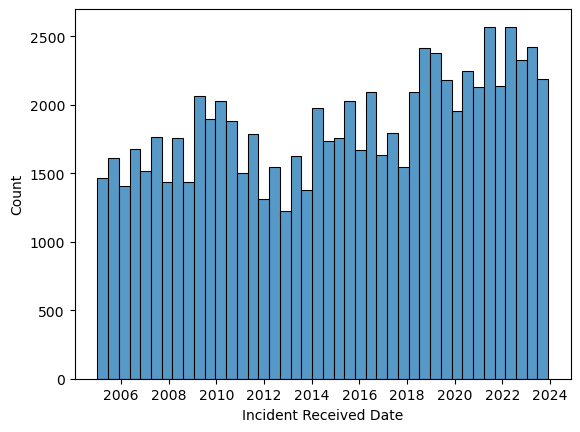

In [104]:
# Looks like more complaints is the trajectory, but what kinds -- low, medium, or high priority?
sns.histplot(df['Incident Received Date']);

In [105]:
# To answer this, I make new dataframes for each of the priority responses.
hi_df = df.loc[(df['Incident Priority'] == 3)]
med_df = df.loc[(df['Incident Priority'] == 2)]
lo_df = df.loc[(df['Incident Priority'] == 1)]

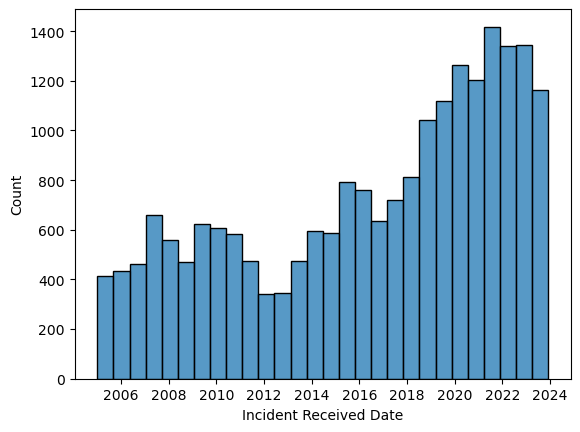

In [107]:
# High Priority complaints are becoming much more common, with rapid increase over the last decade.
sns.histplot(hi_df['Incident Received Date']);

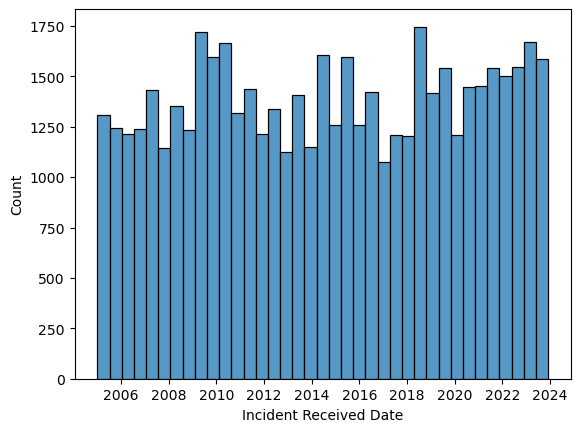

In [108]:
# Medium Priority complaints look fairly stable, but have seen a small upward trend since 2021.
sns.histplot(med_df['Incident Received Date']);

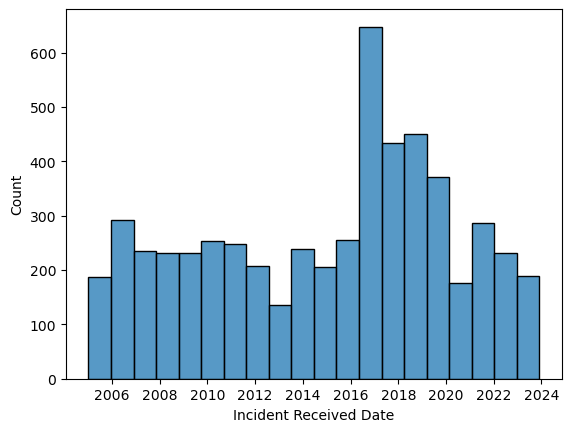

In [109]:
# Interestingly, low priority complaints are strongly trending down. So we're seeing more complaints, and more
# serious risks assosciated with them.
sns.histplot(lo_df['Incident Received Date']);

In [110]:
# Data is as recent as December 6th, 2023.
df['Incident Received Date'].max()

Timestamp('2023-12-06 00:00:00')

In [111]:
# Data dates back to 2005, confirming my previous alteration.
df['Incident Received Date'].min()

Timestamp('2005-01-03 00:00:00')

In [112]:
# This pivot table shows the Incident Priority getting closer to 3 (High Priority) over time, besides a dip in 2023.
df.pivot_table(values = 'Incident Priority', index ='Incident Year', aggfunc=np.mean)

,Incident Priority
Incident Year,
2005,2.118393
2006,2.121573
2007,2.175300
2008,2.148294
2009,2.142185
2010,2.160161
2011,2.108917
2012,2.114117
2013,2.144733


In [113]:
# This further examines the above pivot table, by finding out quantifiably how many High Priority incidents
# happen per year.
hi_df.groupby('Incident Year')['Incident Priority'].count()

Incident Year
2005     609
2006     684
2007     896
2008     772
2009     857
2010     944
2011     620
2012     554
2013     641
2014     929
2015    1073
2016    1111
2017     970
2018    1386
2019    1621
2020    1840
2021    2048
2022    2041
2023    1660
Name: Incident Priority, dtype: int64

In [114]:
# Now looking at Medium Priority response...
med_df.groupby('Incident Year')['Incident Priority'].count()

Incident Year
2005    2485
2006    2396
2007    2519
2008    2529
2009    3138
2010    3016
2011    2578
2012    2475
2013    2467
2014    2778
2015    2828
2016    2510
2017    2214
2018    3003
2019    2900
2020    2585
2021    2992
2022    3094
2023    2918
Name: Incident Priority, dtype: int64

In [115]:
# Finally Low Priority. There are so few low priority incidents, especially since 2020.
lo_df.groupby('Incident Year')['Incident Priority'].count()

Incident Year
2005    217
2006    276
2007    253
2008    246
2009    253
2010    267
2011    245
2012    187
2013    167
2014    264
2015    267
2016    565
2017    443
2018    501
2019    427
2020    214
2021    292
2022    243
2023    185
Name: Incident Priority, dtype: int64

In [116]:
# With 1 meaning Closed, and 2 meaning Referred, we can see that High and Medium Priority complaints are 
# typically closed by TCEQ, while lower priority incidents are referred to other departments or jurisdictions.
df.pivot_table(values = 'Incident Status', index = 'Incident Priority', columns= 'Incident Year')

Incident Year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Incident Priority,,,,,,,,,,,,,,,,,,,
1,1.023041,1.000000,1.019763,1.028455,1.011858,1.044944,1.044898,1.032086,1.035928,1.022727,1.022472,1.005310,1.009029,1.005988,1.000000,1.004673,1.020548,1.000000,1.021622
2,1.022938,1.024624,1.040492,1.041123,1.038560,1.057029,1.051978,1.065051,1.073774,1.053276,1.057638,1.027490,1.032069,1.022311,1.033448,1.029014,1.027406,1.032644,1.053461
3,1.686371,1.646199,1.660714,1.713731,1.690782,1.763771,1.727419,1.747292,1.773791,1.739505,1.803355,1.750675,1.808247,1.790043,1.810611,1.849457,1.867676,1.858403,1.846988


In [117]:
# I was curious if this was evidently tied to towns, but it was not -- every region of Texas skews to referral.
hi_df.pivot_table(values = 'Incident Status', index = 'Region', columns= 'Incident Year')


Incident Year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Region,,,,,,,,,,,,,,,,,,,
1.0,1.500000,1.000000,1.000000,1.363636,2.000000,1.500000,2.000000,1.200000,1.888889,1.950000,2.000000,2.000000,2.000000,1.500000,2.000000,1.700000,1.428571,1.666667,1.923077
2.0,NaN,1.913043,1.857143,1.785714,1.200000,1.058824,1.800000,1.000000,NaN,1.000000,1.266667,1.894737,2.000000,1.820513,1.793103,2.000000,1.931818,2.000000,1.974359
3.0,1.416667,1.769231,1.789474,1.888889,1.785714,1.807692,1.928571,1.857143,1.923077,2.000000,1.928571,1.692308,1.416667,1.846154,1.470588,1.705882,1.800000,1.666667,1.800000
4.0,1.142857,1.583333,1.812500,1.651163,1.719512,1.687500,1.838710,1.926829,1.803922,1.898204,1.929329,1.875421,1.838710,1.906634,1.868852,1.818004,1.823322,1.799043,1.830795
5.0,1.545455,1.594203,1.743590,1.696429,1.852273,1.719512,1.829268,1.739130,1.757143,1.550000,1.416667,1.200000,1.500000,1.500000,1.812500,1.636364,1.696970,1.897436,1.793103
6.0,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,NaN,NaN,NaN,1.000000,2.000000,NaN,1.000000,1.000000,NaN,NaN,2.000000,NaN
7.0,2.000000,1.714286,1.888889,1.935484,1.619048,1.190476,1.250000,1.757576,1.790698,1.941176,1.850000,1.777778,1.600000,1.437500,1.782609,1.666667,2.000000,NaN,2.000000
8.0,1.642857,1.600000,1.866667,2.000000,2.000000,2.000000,1.243902,2.000000,1.437500,1.478261,1.666667,1.727273,1.875000,1.750000,1.764706,2.000000,1.708333,1.761905,2.000000
9.0,1.836066,1.898734,1.941176,1.957895,1.895833,1.983607,1.962963,1.796875,1.923077,1.965217,1.916667,1.886598,1.858824,1.912281,1.944444,1.971429,1.901961,1.927711,1.891304


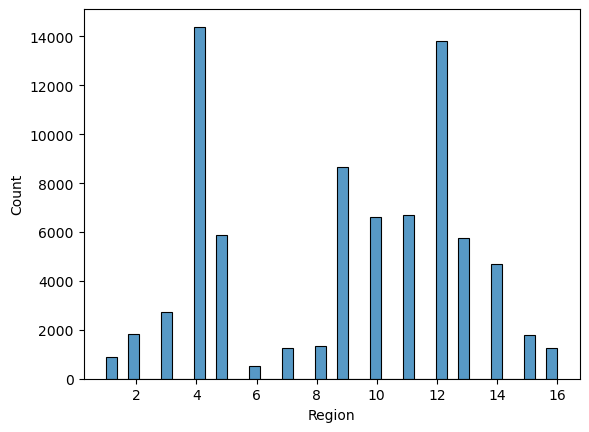

In [210]:
# Here we see that the dataset skews to Region 4 (Waco) and Region 12 (Houston).
sns.histplot(df['Region']);

In [155]:
# Houston has a 2.25 Incident Priority average, so over the past 18 years it's been mostly medium responses.
# Houston has an Incident status of 1.28, so mostly closed cases. There have been 13,800 total complaints.
df[df['Region'] == 12].describe()

,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Incident Year
count,13800.0,13800.000000,13800.000000,13800,13800,13800.000000
mean,12.0,2.248116,1.283043,2016-01-21 23:48:31.304347904,2016-03-20 20:42:46.956521728,2015.576159
min,12.0,1.000000,1.000000,2005-01-04 00:00:00,2005-01-04 00:00:00,2005.000000
25%,12.0,2.000000,1.000000,2011-08-19 00:00:00,2011-10-05 00:00:00,2011.000000
50%,12.0,2.000000,1.000000,2017-01-24 00:00:00,2017-04-19 12:00:00,2017.000000
75%,12.0,3.000000,2.000000,2020-07-21 06:00:00,2020-09-30 00:00:00,2020.000000
max,12.0,3.000000,2.000000,2023-11-30 00:00:00,2023-12-08 00:00:00,2023.000000
std,0.0,0.556956,0.450494,NaN,NaN,5.306764


In [156]:
# Waco has an average Incident Priority of 2.24, and an average Incident status of 1.30. 14,398 complaints.
df[df['Region'] == 4].describe()

,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Incident Year
count,14398.0,14398.000000,14398.000000,14398,14398,14398.000000
mean,4.0,2.237464,1.302750,2015-11-27 05:05:26.545353216,2016-02-02 09:46:52.890679296,2015.421100
min,4.0,1.000000,1.000000,2005-01-04 00:00:00,2005-01-04 00:00:00,2005.000000
25%,4.0,2.000000,1.000000,2011-02-07 00:00:00,2011-04-20 00:00:00,2011.000000
50%,4.0,2.000000,1.000000,2016-08-11 12:00:00,2016-11-29 12:00:00,2016.000000
75%,4.0,3.000000,2.000000,2020-10-22 00:00:00,2020-11-24 00:00:00,2020.000000
max,4.0,3.000000,2.000000,2023-12-06 00:00:00,2023-12-08 00:00:00,2023.000000
std,0.0,0.593610,0.459464,NaN,NaN,5.485259


In [157]:
# Fort Worth / Dallas has an average Incident Priority of 2.20, and an average Incident status of 1.31. 
# 8,673 total complaints.

df[df['Region'] == 9].describe()

,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Incident Year
count,8673.0,8673.000000,8673.000000,8673,8673,8673.000000
mean,9.0,2.199354,1.311772,2013-09-28 09:04:35.198893312,2013-11-23 17:58:42.794880512,2013.251355
min,9.0,1.000000,1.000000,2005-01-03 00:00:00,2005-01-07 00:00:00,2005.000000
25%,9.0,2.000000,1.000000,2009-05-20 00:00:00,2009-06-23 00:00:00,2009.000000
50%,9.0,2.000000,1.000000,2013-02-27 00:00:00,2013-05-17 00:00:00,2013.000000
75%,9.0,2.000000,2.000000,2018-05-07 00:00:00,2018-07-25 00:00:00,2018.000000
max,9.0,3.000000,2.000000,2023-11-28 00:00:00,2023-12-06 00:00:00,2023.000000
std,0.0,0.452840,0.463244,NaN,NaN,5.501447


In [158]:
# Austin has an average Incident Priority of 2.36, an average Incident status of 1.30, and 6,706 complaints.

df[df['Region'] == 11].describe()

,Region,Incident Priority,Incident Status,Incident Received Date,Incident Status Date,Incident Year
count,6706.0,6706.000000,6706.000000,6706,6706,6706.000000
mean,11.0,2.361020,1.302118,2015-09-30 09:03:42.248732672,2015-11-28 15:00:22.546972928,2015.268715
min,11.0,1.000000,1.000000,2005-01-06 00:00:00,2005-01-12 00:00:00,2005.000000
25%,11.0,2.000000,1.000000,2010-01-22 00:00:00,2010-04-21 00:00:00,2010.000000
50%,11.0,2.000000,1.000000,2016-11-29 00:00:00,2017-03-03 00:00:00,2016.000000
75%,11.0,3.000000,2.000000,2021-01-04 00:00:00,2021-02-24 00:00:00,2021.000000
max,11.0,3.000000,2.000000,2023-11-24 00:00:00,2023-12-06 00:00:00,2023.000000
std,0.0,0.524844,0.459210,NaN,NaN,5.799197


## NLP on Incident Description

### NLP Pre-processing on Incident Complaint Descriptions

In [119]:
# Loading in Natural Language Toolkit

nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/marleylopez/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [120]:
# Running a function to simplify the tags into four categories.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [121]:
# Preparing my tokens for my vectorizer.

token_pattern = r'(?:(?<![#@])\b\w+\b)|(?:\b\$[\d.]+\b)|(?:(?<![@])\S+)'
tokenizer = RegexpTokenizer(token_pattern)

In [122]:
# Removing all english stopwords, my notebook was not removing additional stopwords, but I was able to add 
# case-specific stopwords to the Word Clouds.
sw = stopwords.words('english')
#sw.extend(["allege", "complainant","water"])


In [124]:
# Defining my lemmatizer and TF-IDF Vectorizer.

lemmatizer = WordNetLemmatizer()
tf_vec = TfidfVectorizer(token_pattern = token_pattern, stop_words=sw)

In [125]:
# Pre-processing the 'Description' of the incident. Tokenizing the documents, making them lowercase,
# removing numericals, and removing stopwords.

tokenized_docs = [tokenizer.tokenize(doc) for doc in df['Description']]
lower_docs = [[token.lower() for token in doc if token.isalpha()] for doc in tokenized_docs]
sw_docs = [[token for token in doc if token not in sw] for doc in lower_docs]

In [126]:
# Tagging the documents with original UPenn tags.
docs_tagged = [pos_tag(doc) for doc in sw_docs]

In [127]:
# Simplifying the tags with my function, wordnet_docs_tagged.

wordnet_docs_tagged = [[(token[0], get_wordnet_pos(token[1]))
             for token in doc] for doc in docs_tagged]

In [128]:
# Lemmatizing the tagged words.
docs_lemmed = [[lemmatizer.lemmatize(token[0], token[1]) for token in doc]\
               for doc in wordnet_docs_tagged]

In [129]:
# Creating a new column for my pre-processed descriptions.
df['Clean Description'] = docs_lemmed

In [130]:
# Troubleshooting to confirm the descriptions are words.
df['Clean Description'] = df['Clean Description'].astype(str)

### NLP Vectorizing on All Descriptions

In [131]:
# Vectorized the pre-processed descriptions and constructed a dataframe with the results.
X = tf_vec.fit_transform([' '.join(doc) for doc in docs_lemmed])
df_tf = pd.DataFrame(X.toarray(), columns=tf_vec.get_feature_names_out())

In [132]:
# For curiosity's sake, browsed a couple individual TF-IDF rankings, before moving on to more large-scale analysis.
df_tf.iloc[315].sort_values(ascending=False)[:10]

drinking       0.555951
report         0.500521
quality        0.424259
concern        0.417158
water          0.238934
complainant    0.171148
pickup         0.000000
pickp          0.000000
pickle         0.000000
picket         0.000000
Name: 315, dtype: float64

### WordCloud for Priority Complaints

In [133]:
# Pillow allows you to make an image, in this case, for the sake of making my WordClouds look like fish.
from PIL import Image

# Converting image of fish to array. 
# This was successful with other images, but did not end up working for the fish.
mask = np.array(Image.open('Images/fish.png'))

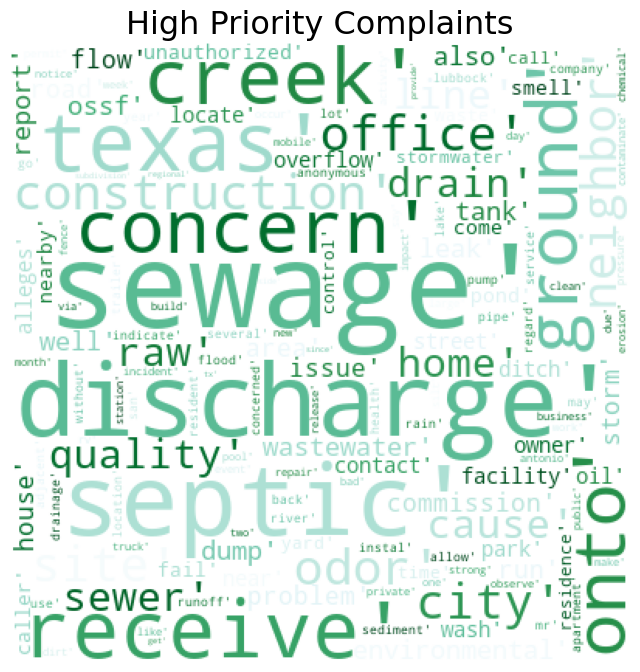

In [208]:
# Selecting high priority complaint descriptions
data = df.loc[(df['Incident Priority'] == 3), 'Clean Description'][:4000]

# Setting up the figure size
plt.figure(figsize=(8,10))

# Creating a WordCloud with specific parameters -- here I added stopwords successfully.
wc = WordCloud(max_words=150, width=400, height=400, stopwords=["complainant'", "complaint'", "county'", "allege'", "water'", "state'", "system'", "property'", "tceq'", "region'"], collocations=False, background_color='white', colormap= 'BuGn').generate(" ".join(data))

# Plotting the WordCloud
plt.title("High Priority Complaints", size=23)
plt.axis('off')
plt.imshow(wc);

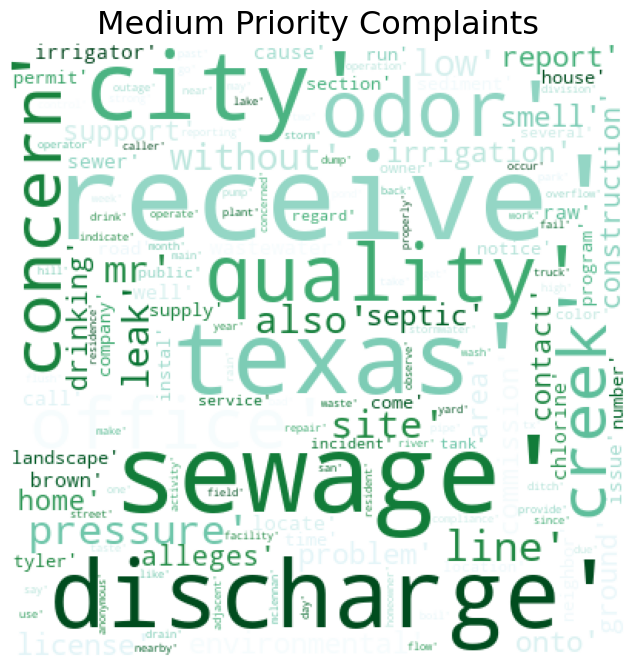

In [204]:
# Selecting medium priority complaint descriptions
data = df.loc[(df['Incident Priority'] == 2), 'Clean Description'][:4000]

# Setting up the figure size
plt.figure(figsize=(10,8))

# Creating a WordCloud with specific parameters
wc = WordCloud(max_words=150, width=400, height=400, stopwords=["complainant'", "complaint'", "county'", "allege'", "water'", "state'", "system'", "property'", "tceq'", "region'"], collocations=False, background_color='white', colormap= 'BuGn').generate(" ".join(data))

# Plotting the WordCloud
plt.title("Medium Priority Complaints", size=23)
plt.axis('off')
plt.imshow(wc);

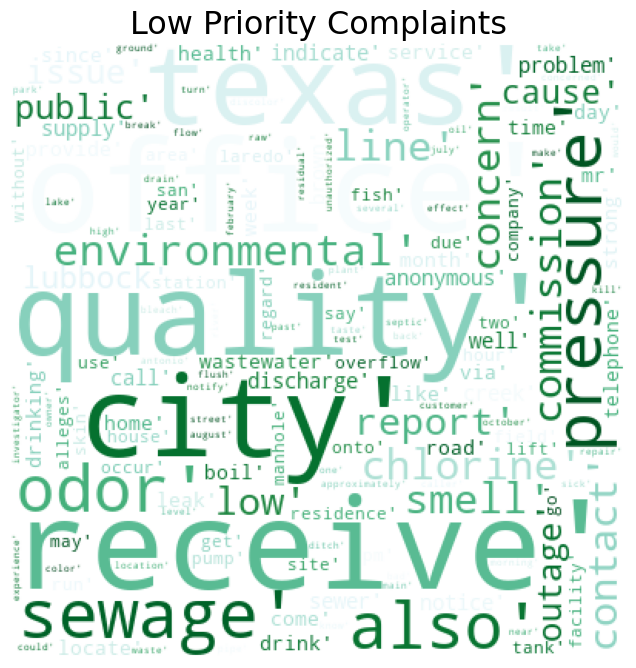

In [209]:
# Selecting low priority complaint descriptions from the lemmatized column.
data = df.loc[(df['Incident Priority'] == 1), 'Clean Description'][:4000]

# Setting up the figure size
plt.figure(figsize=(10,8))

# Creating a WordCloud with specific parameters
wc = WordCloud(max_words=150, width=400, height=400, stopwords=["complainant'", "complaint'", "county'", "allege'", "water'", "state'", "system'", "property'", "tceq'", "region'"], collocations=False, background_color='white', colormap= 'BuGn').generate(" ".join(data))

# Plotting the WordCloud
plt.title("Low Priority Complaints", size=23)
plt.axis('off')
plt.imshow(wc);

### NLP Balanced Dataframe

In [137]:
# Balanced my dataset by randomly sampling larger priority classes to match Low Priority sample size.
low_priority_rows = df.loc[df['Incident Priority'] == 1]
low_priority_samples = low_priority_rows.sample(n=5500, random_state=42)

med_priority_rows = df.loc[df['Incident Priority'] == 2]
med_priority_samples = med_priority_rows.sample(n=5500, random_state=42)

high_priority_rows = df.loc[df['Incident Priority'] == 3]
high_priority_samples = high_priority_rows.sample(n=5500, random_state=42)

In [138]:
# Concatenated the three dataframes, removed additional columns that didn't suit the NLP, reset index.
nlp_df = pd.concat([low_priority_samples, med_priority_samples, high_priority_samples])
nlp_df = nlp_df.drop(columns=['County', 'Region', 'Effect', 'Incident Status', 'Incident Received Date', 'Incident Status Date', 'Frequency'], axis=1)
nlp_df = nlp_df.reset_index(drop=True)
nlp_df.head()

,Incident Priority,Description,Incident Year,Clean Description
0,1,"On July 10, 2014 at 11:15 am, an anonymous com...",2014,"['july', 'anonymous', 'complainant', 'contact'..."
1,1,The TCEQ San Antonio Region received a complai...,2016,"['tceq', 'san', 'antonio', 'region', 'receive'..."
2,1,Complainant alleges that wastewater lift stati...,2005,"['complainant', 'allege', 'wastewater', 'lift'..."
3,1,"On July 30, 2019, the Region 4-Stephenville Of...",2019,"['july', 'region', 'office', 'receive', 'compl..."
4,1,Complainants allege there has been a fish kill...,2020,"['complainant', 'allege', 'fish', 'kill', 'pond']"


In [139]:
# While I had already simplified the Incident Priority column, I wanted to make sure it was encoded
# for best results. This was my finalized, preprocessed dataset for running my NLP model.

label_encoder = LabelEncoder()

nlp_df['Encoded Priority'] = label_encoder.fit_transform(nlp_df['Incident Priority'])

# Display the updated value counts
print(nlp_df['Encoded Priority'].value_counts())

Encoded Priority
0    5500
1    5500
2    5500
Name: count, dtype: int64


### NLP Modeling

In [141]:
# Preparing all X and y variables, for training and test set.
X = nlp_df['Clean Description']
y = nlp_df['Encoded Priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
# Sanity check.
X_train.head()

13117    ['complaint', 'state', 'water', 'bad', 'taste'...
7775     ['complainant', 'contact', 'tceq', 'tyler', 'r...
4153     ['complainant', 'reporting', 'red', 'unknown',...
11430    ['complainant', 'alleges', 'concern', 'regard'...
5903     ['complainant', 'contact', 'tceq', 'tyler', 'r...
Name: Clean Description, dtype: object

### Baseline Multi-class Multinomial Bayes

In [144]:
# Running baseline model.

baseline_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())])

baseline_scores = cross_val_score(baseline_mnb, X_train, y_train, cv=5, scoring="accuracy")

baseline_mnb.fit(X_train, y_train)

baseline_predict_train = cross_val_predict(baseline_mnb,X_train, y_train, cv=5)
baseline_predict_test = cross_val_predict(baseline_mnb, X_test, y_test, cv=5)

# Evaluate the best model on the test set
print("MNB accuracy on the train set:", round((accuracy_score(y_train,baseline_predict_train)),2))
print("MNB accuracy on the test set:", round((accuracy_score(y_test,baseline_predict_test)),2))

report_baseline = classification_report(y_test, baseline_predict_test)
print(report_baseline)

MNB accuracy on the train set: 0.61
MNB accuracy on the test set: 0.56
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      1099
           1       0.54      0.42      0.47      1140
           2       0.56      0.58      0.57      1061

    accuracy                           0.56      3300
   macro avg       0.56      0.57      0.56      3300
weighted avg       0.56      0.56      0.56      3300



In [145]:
# Preparing my predictions for a confusion matrix.
y_hat = baseline_mnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_hat)

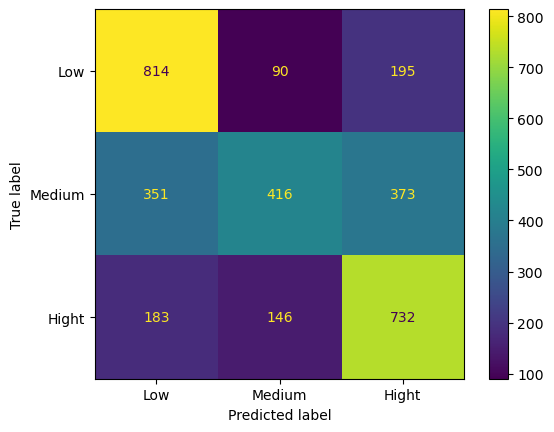

In [146]:
# Most successful at identfying Low Priority, overall weak prediction for Medium Priority.
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low', 'Medium', 'Hight'])
cm_display.plot()
plt.show()

### Gridsearch Multi-Class Multinomial Bayes

In [147]:
# Create a pipeline with TF-IDF Vectorizer and Multinomial Naive Bayes
pipe_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# Define hyperparameter grid for GridSearchCV
param_grid_mnb = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'mnb__alpha': [0.1, 1.0, 10.0]
}

# Perform GridSearchCV
grid_search_mnb = GridSearchCV(pipe_mnb, param_grid_mnb, cv=5, n_jobs=-1)
grid_search_mnb.fit(X_train, y_train)

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search_mnb.best_params_}')

# Best estimator
best_estimator_mnb = grid_search_mnb.best_estimator_

Best hyperparameters: {'mnb__alpha': 0.1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


In [148]:
# Run a second model with best hyperparameters for Multinomial Bayes.
mnb_scores = cross_val_score(best_estimator_mnb, X_train, y_train, cv=5, scoring="accuracy")

best_estimator_mnb.fit(X_train, y_train)

mnb_predict_train = cross_val_predict(best_estimator_mnb,X_train, y_train, cv=5)
mnb_predict_test = cross_val_predict(best_estimator_mnb, X_test, y_test, cv=5)

# Evaluate the best model on the test set
print("MNB accuracy on the train set:", round((accuracy_score(y_train,mnb_predict_train)),2))
print("MNB accuracy on the test set:", round((accuracy_score(y_test,mnb_predict_test)),2))

report_mnb = classification_report(y_test, mnb_predict_test)
print(report_mnb)

MNB accuracy on the train set: 0.63
MNB accuracy on the test set: 0.59
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1099
           1       0.57      0.44      0.50      1140
           2       0.57      0.64      0.60      1061

    accuracy                           0.59      3300
   macro avg       0.59      0.59      0.59      3300
weighted avg       0.59      0.59      0.59      3300



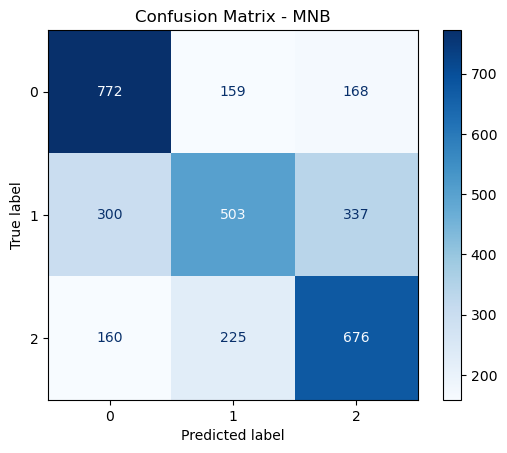

In [149]:
# Again, Low Priority outperforming other priority classes, but High Priority very close. 
# Recall score up 6% from baseline model for High Priority. Medium performing better, too!
# On average, 3% better than baseline.

cm_mnb = confusion_matrix(y_test, mnb_predict_test)
disp_mnb = ConfusionMatrixDisplay(confusion_matrix=cm_mnb)
disp_mnb.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix - MNB')
plt.show();

### Multinomial Logistic Regression

In [150]:
# Create a pipeline with TF-IDF Vectorizer and Logistic Regression
pipe_logreg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(multi_class= 'auto', random_state=42))
])

# Define hyperparameter grid for GridSearchCV
param_grid_logreg = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1, 10],
    'logreg__max_iter': [100, 500, 1000]
}

# Perform GridSearchCV
grid_search_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

# Print the best hyperparameters
print(f'Best hyperparameters: {grid_search_logreg.best_params_}')

# Best estimator
best_estimator_logreg = grid_search_logreg.best_estimator_

/Users/marleylopez/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marleylopez/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Best hyperparameters: {'logreg__C': 1, 'logreg__max_iter': 500, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


In [151]:
# Running best model parameters for Logistic Regression.
logreg_scores = cross_val_score(best_estimator_logreg, X_train, y_train, cv=5, scoring="accuracy")

best_estimator_logreg.fit(X_train, y_train)

logreg_predict_train = cross_val_predict(best_estimator_logreg,X_train, y_train, cv=5)
logreg_predict_test = cross_val_predict(best_estimator_logreg, X_test, y_test, cv=5)

# Evaluate the best model on the test set
print("Logreg accuracy on the train set:", round((accuracy_score(y_train,logreg_predict_train)),2))
print("Logreg accuracy on the test set:", round((accuracy_score(y_test,logreg_predict_test)),2))

report_logreg = classification_report(y_test, logreg_predict_test)
print(report_logreg)


Logreg accuracy on the train set: 0.66
Logreg accuracy on the test set: 0.59
              precision    recall  f1-score   support

           0       0.65      0.68      0.66      1099
           1       0.55      0.51      0.53      1140
           2       0.58      0.60      0.59      1061

    accuracy                           0.59      3300
   macro avg       0.59      0.59      0.59      3300
weighted avg       0.59      0.59      0.59      3300



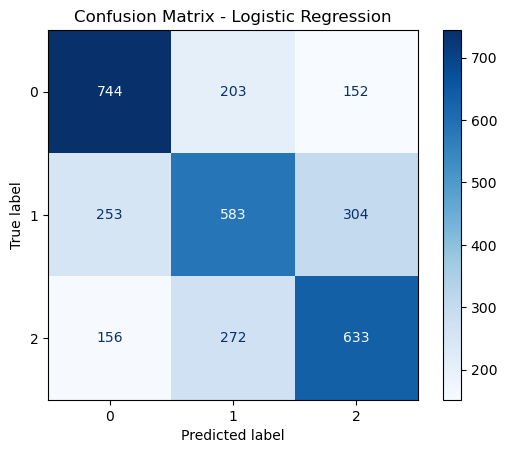

In [152]:
cm_logreg = confusion_matrix(y_test, logreg_predict_test)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg)
disp_logreg.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix - Logistic Regression')
plt.show();

Same average accuracy as multinomial bayes, with a major jump in identifying Medium Priority, when evaluating recall score -- up 7%. But in terms of identifying High Priority, it dips by 4%. I believe successfully identifying High Priority is most relevant to the business problem, and would recommend the multi-class multinomial bayes.